In [1]:
import copy, cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from models import regressionnet
from scripts import tools
from scripts import dataset
from scripts.config import *

%matplotlib inline

tools.etc.set_GPU("2")

In [2]:
net, loss_op, pose_loss_op, train_op = regressionnet.create_regression_net(data_shape=(227,227,3),optimizer_type='adadelta',num_joints=14)
    
with net.graph.as_default():
    saver = tf.train.Saver()
    saver.restore(net.sess, "./out/alexnet_24000.ckpt")
    test_it = dataset.met("/var/data/MET2/activity-met_n10_ub_test.csv", Fliplr=True, Shuffle=True)

INFO:tensorflow:Restoring parameters from ./out/alexnet_24000.ckpt


[Mirroring Images & Coordinates]: 100%|██████████| 53/53 [00:00<00:00, 1057.09it/s]


In [3]:
predicted_joints = net.sess.run(
    [net.fc_regression],
    feed_dict={net.x : test_it.img_set,
    'PoseInput/joints_ground_truth:0' : test_it.coor_set.reshape(len(test_it.coor_set),-1),
    'PoseInput/joints_is_valid:0': test_it.joint_is_valid,
    'lr/conv_lr:0': 1.,
    'lr/fc_lr:0': 1.})[0]
predicted_joints = predicted_joints.reshape(len(predicted_joints),14,2)
pred_canonical = tools.pose.convert2canonical(predicted_joints)
orig_canonical = tools.pose.convert2canonical(test_it.coor_set)

pcp_value=tools.pose.eval_strict_pcp(joints_gt=orig_canonical,predicted_joints=pred_canonical)
average_pcp = tools.pose.average_pcp_left_right_limbs(pcp_value)
print(average_pcp)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.35377358490566035, 0.05896226415094339], ['Head', 'Torso', 'U Arm', 'L Arm', 'U Leg', 'L Leg', 'mean'])


/home/hahnz/git-repo/Human_Action_Estimation/scripts/tools.py:103: RuntimeWarning: divide by zero encountered in float_scalars
  joints_gt[i]['sticks'][stick_id, :2]) / gt_stick_len
/home/hahnz/git-repo/Human_Action_Estimation/scripts/tools.py:105: RuntimeWarning: divide by zero encountered in float_scalars
  joints_gt[i]['sticks'][stick_id, 2:]) / gt_stick_len


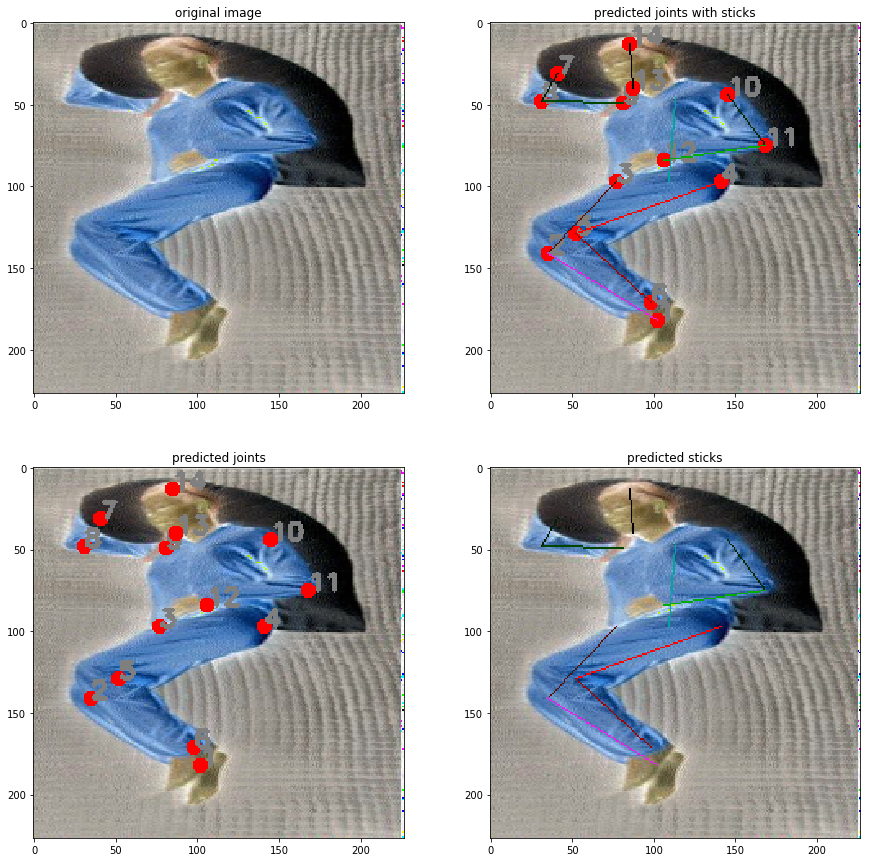

In [4]:
idx=0

pred_img1 = copy.copy(test_it.img_set[idx])
pred_img2 = copy.copy(test_it.img_set[idx])
pred_img3 = copy.copy(test_it.img_set[idx])

pred_joints=tools.etc.markJoints(img=pred_img1, joints=predicted_joints[idx])
pred_sticks=tools.etc.drawSticks(img=pred_img2, sticks=pred_canonical[idx]['sticks'])

pred_joints_with_sticks = tools.etc.markJoints(img=pred_img3, joints=predicted_joints[idx])  
pred_joints_with_sticks = tools.etc.drawSticks(img=pred_img3, sticks=pred_canonical[idx]['sticks'])  

fig, ((p11,p12),(p21,p22)) = plt.subplots(2,2)
fig.set_size_inches(15, 15)

p11.set_title("original image")
p11.imshow(test_it.img_set[idx])
p12.set_title("predicted joints with sticks")
p12.imshow(pred_joints_with_sticks)

p21.set_title("predicted joints")
p21.imshow(pred_img1)
p22.set_title("predicted sticks")
p22.imshow(pred_img2)